### Import required libraries

In [1]:
import numpy as np
import pandas as pd 
import os
import gc
import sklearn.model_selection
from sklearn.linear_model import LinearRegression
import lightgbm as lgb

## suppress warnings
import warnings
warnings.filterwarnings("ignore")

### Process Whole Data

In [2]:
csv_path = "/export/storage_cpoliqui/data/raw/wages2008.tsv"
data = pd.read_csv(csv_path, sep = '\t', header = 0)

## rename all variables
headers = ["firm_id", "establishment_id", "year", "emp_present_12_31", "worker_id",
              "avg_month_wage_in_miniwage", "contract_salary_rea", "salary_type", "weekly_hrs",
              "occupation_code", "reason_leave", "how_worker_entered", "date_enter", "date_left",
              "employment_type", "tenure_in_month", "female", "education_level", "nationality",
              "race", "age", "municipality", "microregion", "corp_form", "industry_cnae"]

data.columns = headers



## based on salary types, tranform contract salary into hourly salary
def transform_sal(sal_type, weekly_hrs, contract_salary_rea):
    
    # 4.333 : monthly factor            sal_type = 1
    # 2.1667 : biweekly factor          sal_type = 2
    # 1 : weekly factor                 sal_type = 3
    # 0.2 : daily factor                sal_type = 4
    # (1/Weekly_hrs) : hourly factor    sal_type = 5
    
    map_a = {1:4.333, 2:2.1667, 3:1, 4:0.2, 5:(1 / Weekly_hrs)}
    return contract_salary_rea / (weekly_hrs * map_a[sal_type])  ## unit of the returned value is
                                                                 ## reais/ hour (hourly salary)
## vectorize "transform_sal" function
v_transform_sal = np.vectorize(transform_sal)



## data wrangling process
def process_data(data_1):
    
    ## exclude any variables that we won't be using for modeling
    data_1.drop(columns = "date_left", inplace = True)           ## drop "date_left"
    data_1.drop(columns = "date_enter", inplace = True)          ## drop "date_enter"
    
    ## for "race", replace all NA entries with the mode of race (the largest race of Brazil)
    mode_race = data_1["race"].mode()
    data_1["race"].fillna(mode_race, inplace = True)
    
    # drop all observations that have any NA entries
    data_1.dropna(inplace = True)
    
    ## transform salary from centavos (cents) to reais (dollars)
    data_1["contract_salary_rea"] = data_1["contract_salary_rea"] / 100
    
    ## exclude sal_type 6 & 7.
    ## Max borrowed this step from Prof Chris's code
    data_1 = data_1.query('salary_type<=5')
    
    ## exclude irrelavant firm IDs and races.
    ## Max borrowed this step from Prof Chris's code
    data_1 = data_1.loc[(data_1["firm_id"] >= 10) & (data_1["race"] != 9)]
    
    ## get rid of any observations with a negative salary
    data_1 = data_1.loc[(data_1["contract_salary_rea"] > 0) &
                        (data_1["avg_month_wage_in_miniwage"] >0)]
    
    ## compute hourly salary using "v_transform_sal()"
    data_1["hr_salary"] = v_transform_sal(data_1["salary_type"].values,
                                          data_1["weekly_hrs"].values,
                                          data_1["contract_salary_rea"].values)
    
    ## take the logarithm of hourly salary
    ## this will be our outcome variable
    data_1.loc[:, "hr_salary_log"] = np.log(data_1["hr_salary"])
    
    ## get rid of a small portion of entries where hourly salary > 1.5
    data_1 = data_1.loc[(data_1["hr_salary"] >= 1.5)]
    ## Max consulted with Prof Chris, who agreed to exclude any observations that have
    ## an hourly salary below the minimum wage of Brazil
    
    data_1 = data_1.reset_index(drop = True)
    return data_1

## the whole data is being processed
data = process_data(data)

### Split single-market firms and multi-market firms

In [3]:
## set aside multi market firms from single market firms
def Single_Multiple(data_1):
    a = data_1.groupby(["firm_id"])["municipality"].nunique()
    
    single_market_id = a.loc[a == 1]
    multi_market_id = a.loc[a != 1]
    multi_market_id = pd.Series(multi_market_id.index)
    single_market_id = pd.Series(single_market_id.index)
    
    single_market_firm = data_1.loc[data_1['firm_id'].isin(single_market_id)]
    multi_market_firm = data_1.loc[data_1['firm_id'].isin(multi_market_id)]
    
    return single_market_firm, multi_market_firm

single_whole, multi_whole = Single_Multiple(data) # whole data

### For single-market firms, split a 10% training set and a 90% testing set

In [4]:
def get_train_test(data_1):
    train, test = sklearn.model_selection.train_test_split(data_1, train_size = 0.1,
                                                           test_size = 0.9,
                                                           random_state = 42)
    print('Train:', train.shape, 'Test:', test.shape)
    train.reset_index(drop = True, inplace = True)
    test.reset_index(drop = True, inplace = True)
    
    return train, test

single_train, single_test = get_train_test(single_whole)



## for LightGBM modeling, we need to exclude any variables that are closely related to
## the outcome variable "hr_salary_log"
def design_matrix(t):
    result = t.drop(columns = ["year", "worker_id", "avg_month_wage_in_miniwage",
                               "contract_salary_rea", "hr_salary_log", "hr_salary",
                               "emp_present_12_31"])
    
    result.reset_index(drop = True, inplace = True)
    return result



def rmse(pred, actual):
    return np.sqrt(np.mean((actual - pred) ** 2))

Train: (3016748, 24) Test: (27150734, 24)


### Transform data into LightGBM format

In [5]:
single_train = design_matrix(single_train)
multi_whole = design_matrix(multi_whole)
single_test = design_matrix(single_test)

### Find the best set of hyper-parameters for the LightGBM model

In [6]:
def tune_lgb(data,                   ## data input, including all predictors and the outcome
             x_var,                  ## an array predictor names
             y_var,                  ## outcome name
             param_arr,              ## an array of hyper-parameter sets, in the form of dictionaries
             k_fold = 10,            ## the k for k-fold cross-validation
             test_size = 0.33,       ## size pf the test size for cross-validation
             random_state = 127,     ## set a random seed for the train-test splitting
             verbose_eval = False):  ## False to turn off log output when fitting the LightGBM
    
    ## import required libraries
    import pandas as pd
    import numpy as np
    import lightgbm as lgb
    import sklearn.model_selection
    
    def rmse(pred, actual):
        return np.sqrt(np.mean((actual - pred) ** 2))
    
    
    ## seperate predictors(x) and outcome(y)
    ## if no specific columns names for x, then use all variables
    if len(x_var) == 0:
        x = data.drop(columns = y_var)
        x.reset_index(drop = True, inplace = True)
    else:
        x = data[x_var].drop(columns = y_var)
        x.reset_index(drop = True, inplace = True)
    
    y = data[y_var]

    mean_rmse = []
    params_final = []
    
    ## test each set of input hyper-parameteres
    for par in param_arr:
        
        params = {'boosting_type': 'gbdt',
                  'objective': 'regression',
                  'metric': 'rmse',
                  'max_depth': -1,
                  'learning_rate': 0.1,
                  'early_stopping_round': 20,
                  'num_leaves': 50,
                  'verbose': -1,
                  'num_iterations': 10000}
        
        params.update(par)
        params_final.append(params)
        
        iter_rmse = []
        
        ## randomly train-test split k times, fit the model, and get a testing RMSE
        
        ## this will be changed to a k-fold cross-validation in the next update
        for i in range(0, k_fold - 1):
            
            x_train, x_test, y_train, y_test = sklearn.model_selection.train_test_split(x, y,
                                                                       test_size = test_size,
                                                                       random_state = random_state + i)
            ## tranform data into LightGBM format
            x_train_lgb = lgb.Dataset(x_train, label = y_train)
            
            ## fit the model using the training set
            model = lgb.train(params, x_train_lgb, valid_sets = x_train_lgb,
                              verbose_eval = verbose_eval)
            
            ## predict using the testing set
            pred = model.predict(x_test)
            
            ## store the testing RMSE
            iter_rmse.append(rmse(pred.reshape(1, -1)[0], y_test))
        
        mean_rmse.append(np.mean(iter_rmse))
    
    ind = mean_rmse.index(np.min(mean_rmse))  ## the index of the smallest average RMSE
    
    print("A minimum mean testing RMSE of", mean_rmse[ind], "is given by parameter set", ind + 1)
    print(param_arr[ind])
    
    return params_final[ind] ## return a complete set of the best hyper-parameters


## Try some arbitury sets of hyper-parameters

### Get the best hyper-parameters

In [7]:
params1 = {'learning_rate': 0.1, "num_leaves": 70}
params2 = {'learning_rate': 0.1, "num_leaves": 80}
params3 = {'learning_rate': 0.1, "num_leaves": 100}
params4 = {'learning_rate': 0.1, "num_leaves": 125}
params5 = {'learning_rate': 0.1, "num_leaves": 150}
params6 = {'learning_rate': 0.1, "num_leaves": 175}
params7 = {'learning_rate': 0.1, "num_leaves": 200}


best_params = tune_lgb(data = single_train, x_var = [], y_var = "hr_salary_log",
                       param_arr = [params1,params2,params3,params4,params5,params6,params7],
                       k_fold = 2)

print(best_params)

A minimum mean testing RMSE of 0.3358337566171561 is given by parameter set 6
{'learning_rate': 0.1, 'num_leaves': 175}
{'boosting_type': 'gbdt', 'objective': 'regression', 'metric': 'rmse', 'max_depth': -1, 'learning_rate': 0.1, 'early_stopping_round': 20, 'num_leaves': 175, 'verbose': -1, 'num_iterations': 10000}


### Fit the model with the 10% training set of single-market firms

In [8]:
single_train_pred = single_train.drop(columns=["hr_salary_log"])
single_test_pred = single_test.drop(columns=["hr_salary_log"])
multi_whole_pred = multi_whole.drop(columns=["hr_salary_log"])

single_train_pred.reset_index(drop = True, inplace = True)
single_test_pred.reset_index(drop = True, inplace = True)
multi_whole_pred.reset_index(drop = True, inplace = True)


single_train_lgb = lgb.Dataset(single_train_pred, label = single_train["hr_salary_log"])

model_lgb = lgb.train(best_params, single_train_lgb, valid_sets = single_train_lgb,
                      verbose_eval = False)

### Predict using the 90% testing set of single-market firms and the entire multi-market firms data

In [9]:
pred_single = model_lgb.predict(single_test_pred).reshape(1, -1)[0]   ## single-market firms, 90% testing set
pred_multi = model_lgb.predict(multi_whole_pred).reshape(1, -1)[0]    ## multi-market firms, entire data

print(rmse(pred_single, single_test["hr_salary_log"]))
print(rmse(pred_multi, multi_whole["hr_salary_log"]))

0.326112932380531
0.6240823315644706


## Do multi-market firms inadequately adjust their wages across markets?

### regression of true wage against predicted wage for multi-market firm employees

In [10]:
import statsmodels.api as sm

pred_multi_lm = sm.add_constant(pred_multi)

lm_multi = sm.OLS(multi_whole["hr_salary_log"], pred_multi_lm).fit()    # multi-market firms
lm_multi.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          hr_salary_log   R-squared:                       0.520
Model:                            OLS   Adj. R-squared:                  0.520
Method:                 Least Squares   F-statistic:                 1.581e+07
Date:                Tue, 05 May 2020   Prob (F-statistic):               0.00
Time:                        02:31:15   Log-Likelihood:            -1.3735e+07
No. Observations:            14609508   AIC:                         2.747e+07
Df Residuals:                14609506   BIC:                         2.747e+07
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1660      0.000    421.219      0.000       0.165       0.167
x1             0.9289      0.000   3976.295      0.000       0.928       0.929
==============================================================================
Omnibus:                 12516339.447   Durbin-Watson:                   0.707
Prob(Omnibus):                  0.000   Jarque-Bera (JB):        710578834.579
Skew:                           3.844   Prob(JB):                         0.00
Kurtosis:                      36.290   Cond. No.                         5.36
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### regression for single-market firm employees

In [11]:
pred_single_lm = sm.add_constant(pred_single)

lm_single = sm.OLS(single_test["hr_salary_log"], pred_single_lm).fit()  # single-market firms (for comparision)
lm_single.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          hr_salary_log   R-squared:                       0.758
Model:                            OLS   Adj. R-squared:                  0.758
Method:                 Least Squares   F-statistic:                 8.506e+07
Date:                Tue, 05 May 2020   Prob (F-statistic):               0.00
Time:                        02:31:24   Log-Likelihood:            -8.0982e+06
No. Observations:            27150734   AIC:                         1.620e+07
Df Residuals:                27150732   BIC:                         1.620e+07
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0132      0.000    -84.598      0.000      -0.013      -0.013
x1             1.0102      0.000   9222.717      0.000       1.010       1.010
==============================================================================
Omnibus:                 23426348.345   Durbin-Watson:                   2.000
Prob(Omnibus):                  0.000   Jarque-Bera (JB):       3512389485.179
Skew:                           3.532   Prob(JB):                         0.00
Kurtosis:                      58.271   Cond. No.                         5.08
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## feature importance graph

<Figure size 1080x432 with 0 Axes>

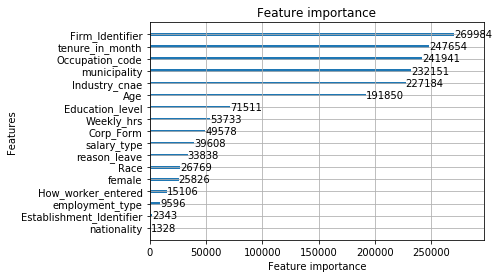

In [23]:
import matplotlib.pyplot as plt

plt.figure(figsize = (15, 6))
lgb.plot_importance(model_lgb)
plt.savefig("feature_importance", dpi = 400)